--- LAPORAN KESEHATAN DATA ---
Total Hari Kerja Seharusnya : 2609 hari
Total Data Tersedia         : 2423 hari
Jumlah Data Hilang          : 194 hari
Contoh Tanggal Hilang       : [Timestamp('2015-12-09 00:00:00'), Timestamp('2015-12-24 00:00:00'), Timestamp('2015-12-25 00:00:00'), Timestamp('2015-12-31 00:00:00'), Timestamp('2016-01-01 00:00:00')]

--- LAPORAN ANOMALI (VOLATILITAS) ---
Jumlah Hari dengan Pergerakan > 5% : 51 hari
Top 5 Pergerakan Paling Ekstrem:
             Close    Return
Date                        
2020-03-26  5975.0  0.183168
2020-03-27  6800.0  0.138075
2015-11-30  4875.0 -0.097222
2020-02-12  7000.0 -0.087948
2019-03-25  6775.0 -0.084459


C:\Users\user\AppData\Local\Temp\ipykernel_32200\3500660019.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Return'] = df['Close'].pct_change() # Hitung % perubahan harian


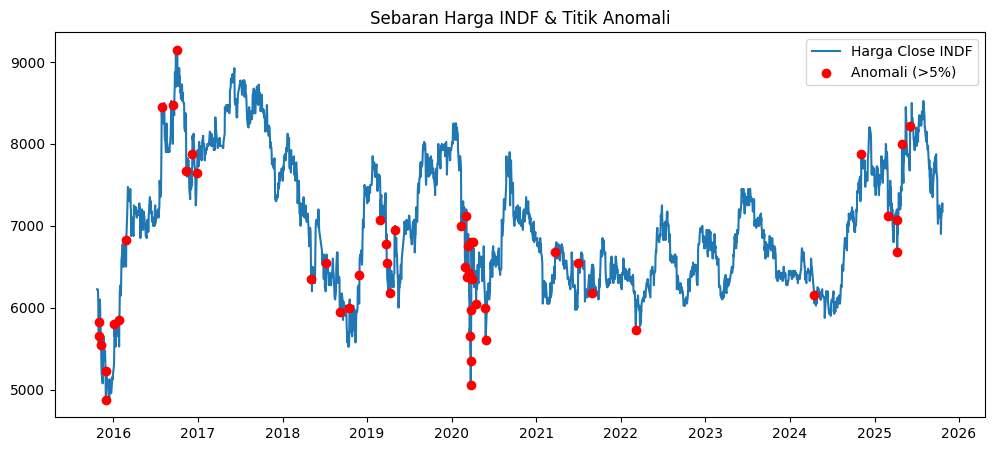

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. BACA DATA (Format Khusus: Pemisah titik koma & Ribuan titik)
df = pd.read_csv('Data Historis INDF.csv', sep=';', thousands='.')

# 2. GANTI NAMA KOLOM & FORMAT TANGGAL
df = df.rename(columns={'Tanggal': 'Date', 'Terakhir': 'Close'})
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df = df.sort_values('Date').set_index('Date')

# 3. CEK MISSING VALUES (Hari Kerja yang Bolong)
all_business_days = pd.date_range(start=df.index.min(), end=df.index.max(), freq='B')
missing_dates = all_business_days.difference(df.index)

print(f"--- LAPORAN KESEHATAN DATA ---")
print(f"Total Hari Kerja Seharusnya : {len(all_business_days)} hari")
print(f"Total Data Tersedia         : {len(df)} hari")
print(f"Jumlah Data Hilang          : {len(missing_dates)} hari")
print(f"Contoh Tanggal Hilang       : {missing_dates[:5].tolist()}")

# 4. CEK ANOMALI (Perubahan Harga Ekstrem > 5%)
df['Return'] = df['Close'].pct_change() # Hitung % perubahan harian
anomalies = df[abs(df['Return']) > 0.05] # Ambil yang perubahannya > 5%

print(f"\n--- LAPORAN ANOMALI (VOLATILITAS) ---")
print(f"Jumlah Hari dengan Pergerakan > 5% : {len(anomalies)} hari")
print("Top 5 Pergerakan Paling Ekstrem:")
print(anomalies[['Close', 'Return']].sort_values(by='Return', key=abs, ascending=False).head())

# 5. VISUALISASI SEDERHANA
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Close'], label='Harga Close INDF')
plt.scatter(anomalies.index, anomalies['Close'], color='red', label='Anomali (>5%)', zorder=5)
plt.title('Sebaran Harga INDF & Titik Anomali')
plt.legend()
plt.show()

In [21]:
import pandas as pd
import numpy as np

print("--- MEMULAI PERBAIKAN DATA (FINAL FIX) ---")

# 1. LOAD DATA ULANG (Pastikan start dari awal biar bersih)
df = pd.read_csv('Data Historis INDF.csv', sep=';', thousands='.')

# 2. STANDARDISASI KOLOM
df = df.rename(columns={'Tanggal': 'Date', 'Terakhir': 'Close'})
df = df[['Date', 'Close']] 

# 3. FORMAT TANGGAL & INDEX
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df = df.sort_values('Date').set_index('Date')

# ========================================================
# LANGKAH PERBAIKAN ERROR (HAPUS TANGGAL GANDA)
# ========================================================
jumlah_duplikat = df.index.duplicated().sum()
if jumlah_duplikat > 0:
    print(f"⚠️ DITEMUKAN {jumlah_duplikat} TANGGAL GANDA! Sedang menghapus...")
    # Kita ambil data yang pertama muncul (keep='first') dan buang sisanya
    df = df[~df.index.duplicated(keep='first')]
    print("✅ Duplikat berhasil dihapus.")
else:
    print("✅ Tidak ada tanggal ganda. Aman.")

# ========================================================
# LANJUT KE REINDEXING & INTERPOLASI
# ========================================================

# 4. BUAT INDEX LENGKAP (BUSINESS DAYS)
all_business_days = pd.date_range(start=df.index.min(), end=df.index.max(), freq='B')

# 5. REINDEXING (Sekarang pasti berhasil karena duplikat sudah hilang)
df_clean = df.reindex(all_business_days)

# 6. INTERPOLASI LINEAR (Isi data libur)
df_clean['Close'] = df_clean['Close'].interpolate(method='linear', limit_direction='both')

# 7. PEMBULATAN
df_clean['Close'] = df_clean['Close'].round(0)

# ========================================================
# CEK HASIL & SIMPAN
# ========================================================
print(f"\n--- STATUS AKHIR ---")
print(f"Sisa Data Kosong : {df_clean['Close'].isnull().sum()} (Harus 0)")
print(f"Total Baris Data : {len(df_clean)}")

# Simpan
df_clean.to_csv('INDF_Cleaned.csv', index_label='Date')
print("\n🎉 SUKSES! File bersih tersimpan sebagai: 'INDF_Cleaned.csv'")

--- MEMULAI PERBAIKAN DATA (FINAL FIX) ---
⚠️ DITEMUKAN 7 TANGGAL GANDA! Sedang menghapus...
✅ Duplikat berhasil dihapus.

--- STATUS AKHIR ---
Sisa Data Kosong : 0 (Harus 0)
Total Baris Data : 2609

🎉 SUKSES! File bersih tersimpan sebagai: 'INDF_Cleaned.csv'


In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# Agar hasil eksperimen bisa direproduksi (adil)
tf.random.set_seed(42)
np.random.seed(42)

# Load data bersih
df = pd.read_csv('INDF_Cleaned.csv', parse_dates=['Date'], index_col='Date')
data_full = df[['Close']].values

# Parameter Tetap
WINDOW_SIZE = 30

# Fungsi untuk membuat window (seperti sebelumnya)
def create_window_dataset(dataset, lookback):
    X, y = [], []
    for i in range(lookback, len(dataset)):
        X.append(dataset[i-lookback:i])
        y.append(dataset[i])
    return np.array(X), np.array(y)

# ==========================================
# INTI: FUNGSI PEMBAGI SKENARIO
# ==========================================
def jalankan_skenario(ratio_train, ratio_val, ratio_test):
    print(f"\n>>> MENJALANKAN SKENARIO {int(ratio_train*100)}:{int(ratio_val*100)}:{int(ratio_test*100)} ...")
    
    n = len(data_full)
    n_train = int(ratio_train * n)
    n_val = int(ratio_val * n)
    # Sisanya buat test (biar total pas 100%)
    n_test = n - n_train - n_val 
    
    # 1. Splitting
    train_data = data_full[:n_train]
    val_data   = data_full[n_train:n_train+n_val]
    test_data  = data_full[-n_test:]
    
    # 2. Scaling (FIT HANYA DI TRAIN!)
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_data)
    val_scaled   = scaler.transform(val_data)
    test_scaled  = scaler.transform(test_data)
    
    # 3. Windowing
    X_train, y_train = create_window_dataset(train_scaled, WINDOW_SIZE)
    X_val, y_val     = create_window_dataset(val_scaled, WINDOW_SIZE)
    X_test, y_test   = create_window_dataset(test_scaled, WINDOW_SIZE)
    
    print(f"   Shape Train: {X_train.shape}")
    print(f"   Shape Val  : {X_val.shape}")
    print(f"   Shape Test : {X_test.shape}")
    
    # KEMBALIKAN DATA YANG SUDAH SIAP
    return {
        'X_train': X_train, 'y_train': y_train,
        'X_val': X_val, 'y_val': y_val,
        'X_test': X_test, 'y_test': y_test,
        'scaler': scaler # Scaler butuh disimpan buat invers nanti
    }

# ==========================================
# EKSEKUSI 3 SKENARIO
# ==========================================
# List skenario: (Train, Val, Test)
skenario_list = [
    (0.80, 0.10, 0.10),
    (0.70, 0.15, 0.15),
    (0.60, 0.20, 0.20)
]

# Dictionary untuk menyimpan semua data siap pakai
datasets = {}

for r_train, r_val, r_test in skenario_list:
    nama_skenario = f"{int(r_train*100)}-{int(r_val*100)}-{int(r_test*100)}"
    
    # Panggil fungsi di atas
    datasets[nama_skenario] = jalankan_skenario(r_train, r_val, r_test)

print("\n✅ SEMUA SKENARIO SUDAH DIPROSES & DISIMPAN!")
print("Cara akses data: datasets['80-10-10']['X_train']")


>>> MENJALANKAN SKENARIO 80:10:10 ...
   Shape Train: (2057, 30, 1)
   Shape Val  : (230, 30, 1)
   Shape Test : (232, 30, 1)

>>> MENJALANKAN SKENARIO 70:15:15 ...
   Shape Train: (1796, 30, 1)
   Shape Val  : (361, 30, 1)
   Shape Test : (362, 30, 1)

>>> MENJALANKAN SKENARIO 60:20:20 ...
   Shape Train: (1535, 30, 1)
   Shape Val  : (491, 30, 1)
   Shape Test : (493, 30, 1)

✅ SEMUA SKENARIO SUDAH DIPROSES & DISIMPAN!
Cara akses data: datasets['80-10-10']['X_train']


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. FUNGSI BANGUN MODEL (Sederhana: 1 Layer CNN + 1 Layer BiLSTM)
def build_simple_hybrid_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        
        # HANYA 1 LAYER CNN
        # filters=32 sesuai rekomendasi awal di jurnal untuk ekstraksi fitur utama [cite: 354, 384]
        Conv1D(filters=32, kernel_size=3, activation='relu'), 
        MaxPooling1D(pool_size=2), # Menghilangkan noise dan mereduksi dimensi
        
        # HANYA 1 LAYER BiLSTM
        # units=50 atau 64 adalah titik tengah yang stabil [cite: 354, 384]
        Bidirectional(LSTM(units=50, return_sequences=False)), 
        
        Dropout(0.2), # Menjaga agar model tetap general (tidak kaku)
        
        # Langsung ke Dense Layer
        Dense(units=16, activation='relu'),
        Dense(units=1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# 2. PROSES TRAINING OTOMATIS (MENGGUNAKAN LOOP DATASETS SEBELUMNYA)
results_simple = {}

for nama, ds in datasets.items():
    print(f"\n--- TRAINING SKENARIO {nama} (VERSION: 1-LAYER) ---")
    
    input_shape = (ds['X_train'].shape[1], ds['X_train'].shape[2])
    model = build_simple_hybrid_model(input_shape)
    
    # Gunakan Early Stopping agar model berhenti di titik paling optimal [cite: 337]
    callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(
        ds['X_train'], ds['y_train'],
        validation_data=(ds['X_val'], ds['y_val']),
        epochs=100, 
        batch_size=100, 
        callbacks=[callback],
        verbose=1
    )
    
    results_simple[nama] = {
        'model': model,
        'history': history.history
    }

print("\n✅ TRAINING 1-LAYER SELESAI!")


--- TRAINING SKENARIO 80-10-10 (VERSION: 1-LAYER) ---
Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0443 - val_loss: 0.0045
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0105 - val_loss: 0.0025
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0080 - val_loss: 0.0021
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0067 - val_loss: 0.0019
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0064 - val_loss: 0.0019
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0054 - val_loss: 0.0016
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0046 - val_loss: 0.0013
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041 - val_loss: 0.0010
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - val_loss: 8.3034e-04
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - val_loss: 8.4827e-04
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027 - val_lo


--- Mengevaluasi Skenario 80-10-10 ---


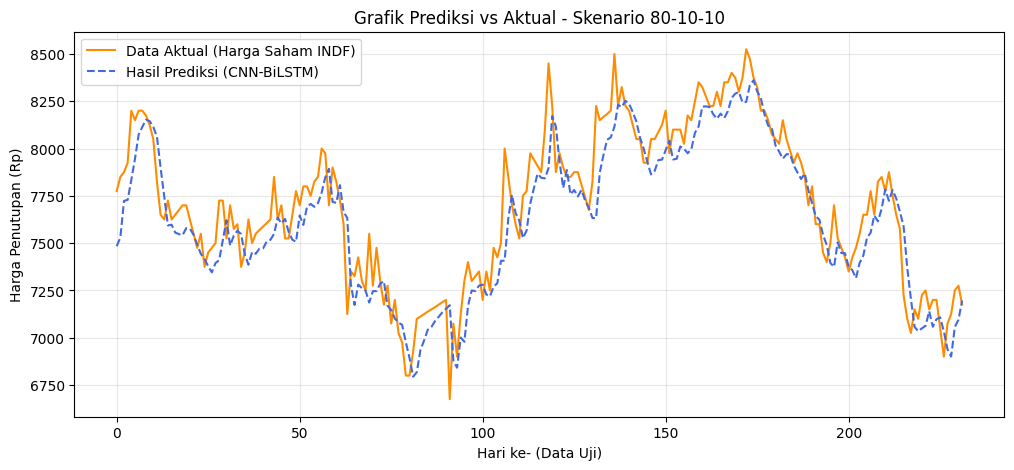


--- Mengevaluasi Skenario 70-15-15 ---


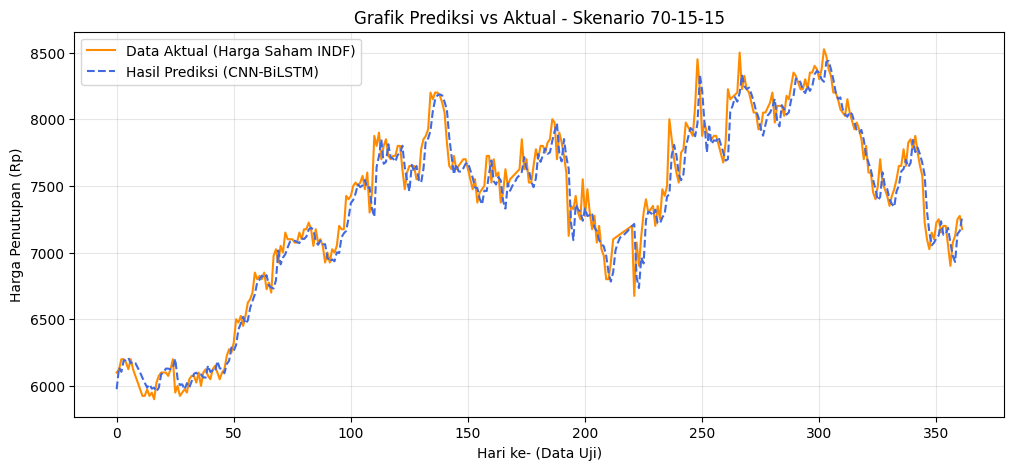


--- Mengevaluasi Skenario 60-20-20 ---


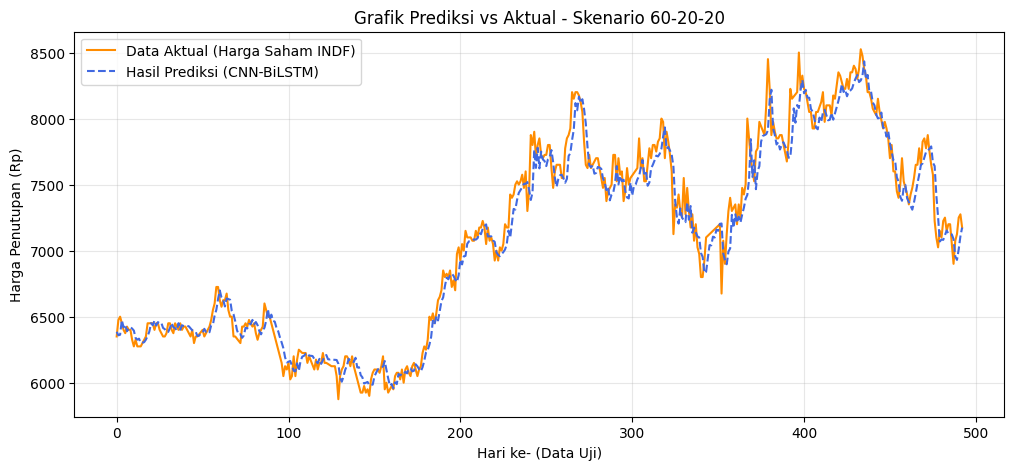


TABEL REKAPITULASI PERFORMA MODEL CNN-BiLSTM


,Skenario (Train:Val:Test),RMSE (Rupiah),MAE (Rupiah),MAPE (%),R-Squared (R2),Kategori Akurasi
0,80:10:10,164.65,127.28,1.65,0.8314,Sangat Akurat
1,70:15:15,132.80,97.76,1.32,0.9607,Sangat Akurat
2,60:20:20,131.36,94.39,1.30,0.9680,Sangat Akurat


In [24]:
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ==========================================
# 1. FUNGSI EVALUASI LENGKAP (SESUAI PROPOSAL & JURNAL)
# ==========================================
def hitung_metrik(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    
    # Penentuan Kategori MAPE berdasarkan Skala Lewis (Mushliha, 2024)
    if mape < 10:
        kategori = "Sangat Akurat"
    elif 10 <= mape < 20:
        kategori = "Baik"
    elif 20 <= mape < 50:
        kategori = "Normal"
    else:
        kategori = "Tidak Akurat"
        
    return rmse, mae, mape, r2, kategori

# ==========================================
# 2. PROSES EVALUASI UNTUK SEMUA SKENARIO
# ==========================================
rekap_hasil = []

for nama, ds in datasets.items():
    print(f"\n--- Mengevaluasi Skenario {nama} ---")
    
    # Ambil model terbaik dari hasil training sebelumnya
    model = results_simple[nama]['model']
    scaler = ds['scaler']
    
    # a. Prediksi pada Data Uji (Test Set)
    y_pred_scaled = model.predict(ds['X_test'], verbose=0)
    
    # b. Invers Scaling (Kembalikan angka 0-1 ke Harga Rupiah Asli)
    y_test_asli = scaler.inverse_transform(ds['y_test'].reshape(-1, 1))
    y_pred_asli = scaler.inverse_transform(y_pred_scaled)
    
    # c. Hitung Semua Metrik (MAE, RMSE, MAPE, R2)
    rmse, mae, mape, r2, kat = hitung_metrik(y_test_asli, y_pred_asli)
    
    # Simpan ke daftar rekap
    rekap_hasil.append({
        'Skenario (Train:Val:Test)': nama.replace('-', ':'),
        'RMSE': round(rmse, 2),
        'MAE': round(mae, 2),
        'MAPE (%)': round(mape, 2),
        'R-Squared': round(r2, 4),
        'Kategori': kat
    })
    
    # d. Visualisasi Grafik Perbandingan (Sesuai Bab 3 Metodologi)
    plt.figure(figsize=(12, 5))
    plt.plot(y_test_asli, label='Data Aktual (Harga Saham INDF)', color='darkorange', linewidth=1.5)
    plt.plot(y_pred_asli, label='Hasil Prediksi (CNN-BiLSTM)', color='royalblue', linestyle='--', linewidth=1.5)
    plt.title(f'Grafik Prediksi vs Aktual - Skenario {nama}')
    plt.xlabel('Hari ke- (Data Uji)')
    plt.ylabel('Harga Penutupan (Rp)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# ==========================================
# 3. TAMPILKAN TABEL HASIL AKHIR (UNTUK BAB 4 TA)
# ==========================================
# Membuat DataFrame dari list rekap_hasil yang sudah kita kumpulkan tadi
df_hasil_akhir = pd.DataFrame(rekap_hasil)

# Mengatur tampilan kolom agar lebih rapi
df_hasil_akhir.columns = [
    'Skenario (Train:Val:Test)', 
    'RMSE (Rupiah)', 
    'MAE (Rupiah)', 
    'MAPE (%)', 
    'R-Squared (R2)', 
    'Kategori Akurasi'
]

# Menampilkan tabel
print("\n" + "="*80)
print("TABEL REKAPITULASI PERFORMA MODEL CNN-BiLSTM")
print("="*80)
display(df_hasil_akhir) # Menggunakan display agar tampilan di Notebook lebih cantik
print("="*80)

# (Opsional) Simpan tabel ke Excel jika Anda ingin memasukkannya ke lampiran TA
# df_hasil_akhir.to_excel('Hasil_Eksperimen_Skenario.xlsx', index=False)

==========================================
PERCOBAAN KEDUA: OPTIMASI (2-LAYER & WINDOW 10)
==========================================

--- MEMULAI EKSPERIMEN 2 (2-LAYER & WINDOW 10) ---

Proses Skenario 80:10:10...


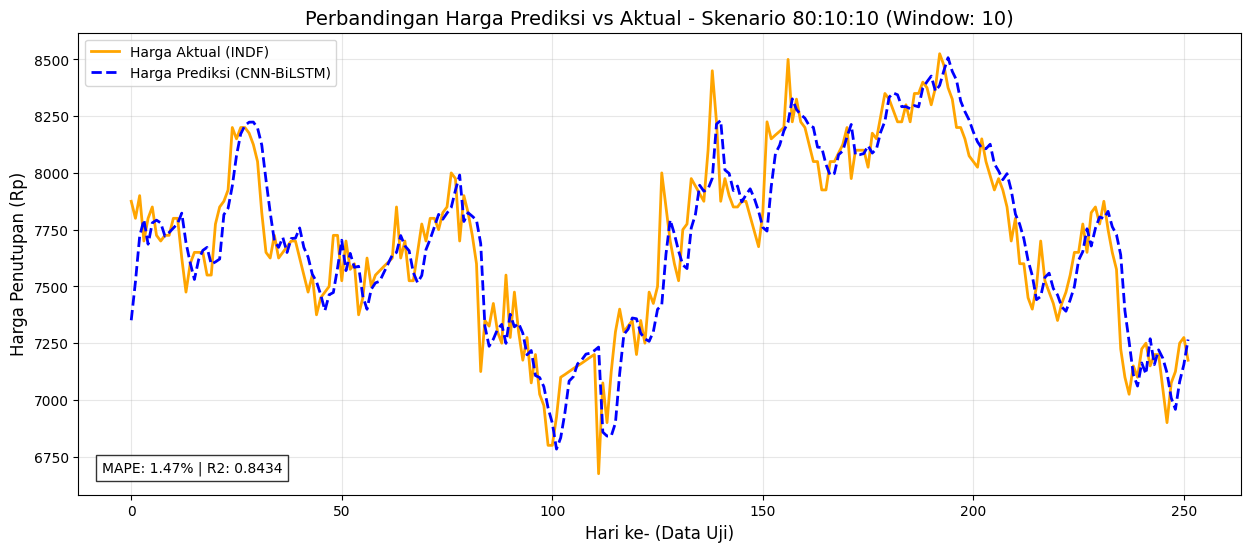


Proses Skenario 70:15:15...


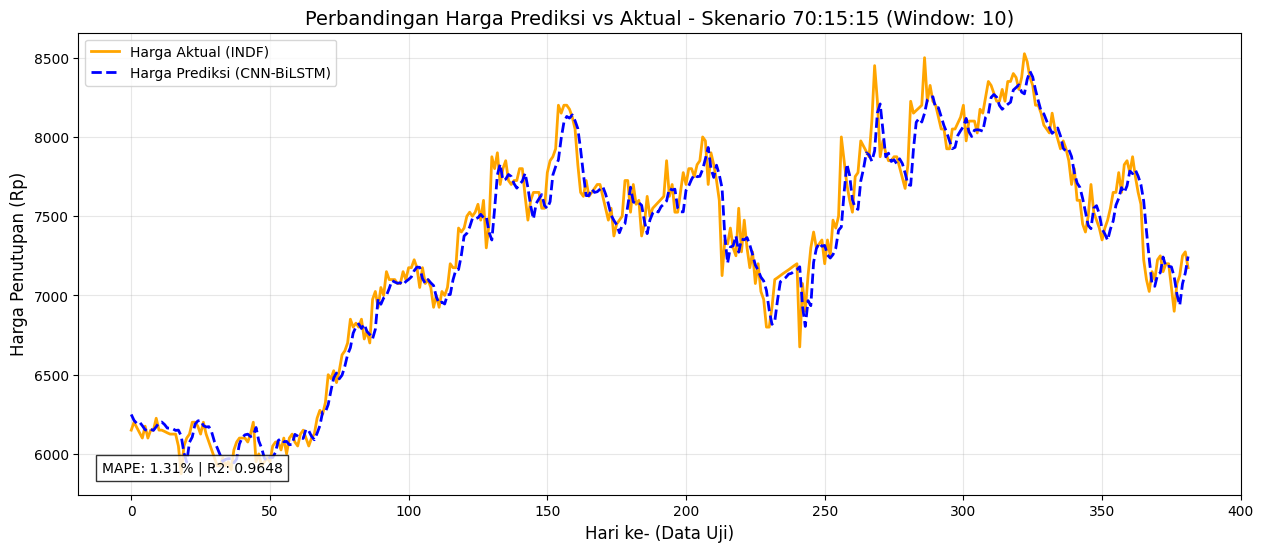


Proses Skenario 60:20:20...


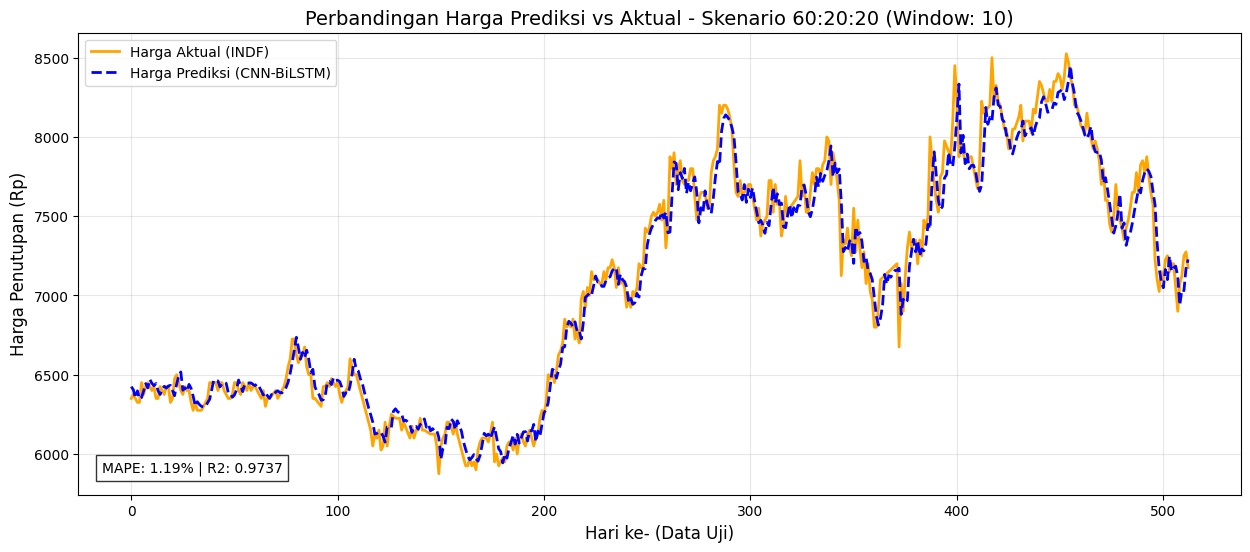


HASIL PERCOBAAN 2: ARSITEKTUR 2-LAYER (WINDOW 10)
Skenario       RMSE        MAE  MAPE (%)       R2      Kategori
80:10:10 152.768736 112.464032  1.471109 0.843381 Sangat Akurat
70:15:15 132.902461  96.854826  1.313589 0.964799 Sangat Akurat
60:20:20 118.850016  85.466167  1.187151 0.973736 Sangat Akurat


In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Dropout, Input, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ==========================================
# 1. FUNGSI PENDUKUNG (DIURUTKAN AGAR TIDAK ERROR)
# ==========================================

# Fungsi Sliding Window [cite: 329, 564, 775]
def create_window_dataset(dataset, lookback):
    X, y = [], []
    for i in range(lookback, len(dataset)):
        X.append(dataset[i-lookback:i])
        y.append(dataset[i])
    return np.array(X), np.array(y)

# Fungsi Skenario Pembagian Data [cite: 333, 552, 715]
def jalankan_skenario_v2(ratio_train, ratio_val, ratio_test, window_size):
    # Load data bersih
    df_temp = pd.read_csv('INDF_Cleaned.csv', parse_dates=['Date'], index_col='Date')
    data_raw = df_temp[['Close']].values
    
    n = len(data_raw)
    n_train = int(ratio_train * n)
    n_val = int(ratio_val * n)
    n_test = n - n_train - n_val 
    
    train_data = data_raw[:n_train]
    val_data   = data_raw[n_train:n_train+n_val]
    test_data  = data_raw[-n_test:]
    
    scaler = MinMaxScaler(feature_range=(0, 1)) 
    train_scaled = scaler.fit_transform(train_data)
    val_scaled   = scaler.transform(val_data)
    test_scaled  = scaler.transform(test_data)
    
    X_train, y_train = create_window_dataset(train_scaled, window_size)
    X_val, y_val     = create_window_dataset(val_scaled, window_size)
    X_test, y_test   = create_window_dataset(test_scaled, window_size)
    
    return {'X_train': X_train, 'y_train': y_train, 'X_val': X_val, 'y_val': y_val, 
            'X_test': X_test, 'y_test': y_test, 'scaler': scaler}

# Fungsi Metrik Evaluasi [cite: 98, 375, 703]
def hitung_metrik_v2(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred) 
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 
    r2 = r2_score(y_true, y_pred) 
    kategori = "Sangat Akurat" if mape < 10 else "Baik" if mape < 20 else "Normal" 
    return rmse, mae, mape, r2, kategori

# ==========================================
# 2. EKSEKUSI PERCOBAAN KEDUA
# ==========================================

print("--- MEMULAI EKSPERIMEN 2 (2-LAYER & WINDOW 10) ---")

skenario_list = [(0.8, 0.1, 0.1), (0.7, 0.15, 0.15), (0.6, 0.2, 0.2)]
WINDOW_SIZE_2 = 10  # Window size diuji sesuai referensi
rekap_exp2 = []

for r_train, r_val, r_test in skenario_list:
    nama = f"{int(r_train*100)}:{int(r_val*100)}:{int(r_test*100)}"
    print(f"\nProses Skenario {nama}...")
    
    # Preprocessing
    ds = jalankan_skenario_v2(r_train, r_val, r_test, WINDOW_SIZE_2)
    
    # Arsitektur 2-Layer [cite: 784, 787, 826]
    model = Sequential([
        Input(shape=(ds['X_train'].shape[1], 1)),
        Conv1D(filters=32, kernel_size=3, activation='relu'), 
        Conv1D(filters=16, kernel_size=3, activation='relu'), 
        MaxPooling1D(pool_size=2), 
        Bidirectional(LSTM(units=64, return_sequences=True)), 
        Bidirectional(LSTM(units=32, return_sequences=False)), 
        Dropout(0.2),
        Dense(units=16, activation='relu'), 
        Dense(units=1) 
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error') 
    
    # Training dengan Early Stopping [cite: 360, 363]
    callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(ds['X_train'], ds['y_train'], validation_data=(ds['X_val'], ds['y_val']),
              epochs=100, batch_size=100, callbacks=[callback], verbose=0)
    
    # Prediksi & Invers Scaling [cite: 368, 701]
    y_pred_scaled = model.predict(ds['X_test'], verbose=0)
    y_test_asli = ds['scaler'].inverse_transform(ds['y_test'].reshape(-1, 1))
    y_pred_asli = ds['scaler'].inverse_transform(y_pred_scaled)
    
    # Rekap
    rmse, mae, mape, r2, kat = hitung_metrik_v2(y_test_asli, y_pred_asli)
    rekap_exp2.append({'Skenario': nama, 'RMSE': rmse, 'MAE': mae, 'MAPE (%)': mape, 'R2': r2, 'Kategori': kat})
    import matplotlib.pyplot as plt

    
    # 4. VISUALISASI GRAFIK PERBANDINGAN [cite: 380, 865]
    plt.figure(figsize=(15, 6))
    plt.plot(y_test_asli, label='Harga Aktual (INDF)', color='orange', linewidth=2)
    plt.plot(y_pred_asli, label='Harga Prediksi (CNN-BiLSTM)', color='blue', linestyle='--', linewidth=2)
    
    # Menambahkan detail grafik sesuai standar jurnal [cite: 855]
    plt.title(f'Perbandingan Harga Prediksi vs Aktual - Skenario {nama} (Window: {WINDOW_SIZE_2})', fontsize=14)
    plt.xlabel('Hari ke- (Data Uji)', fontsize=12)
    plt.ylabel('Harga Penutupan (Rp)', fontsize=12)
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Menampilkan metrik pada grafik agar informatif
    plt.text(0.02, 0.05, f'MAPE: {mape:.2f}% | R2: {r2:.4f}', 
             transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.show()

# [Tabel rekap tetap dicetak di akhir setelah loop selesai]

# 3. TAMPILKAN TABEL
print("\n" + "="*80)
print("HASIL PERCOBAAN 2: ARSITEKTUR 2-LAYER (WINDOW 10)")
print("="*80)
print(pd.DataFrame(rekap_exp2).to_string(index=False))

 ========================================================
 1. PENGGABUNGAN DATA PERCOBAAN 1 & 2
 ========================================================

❌ Terjadi kesalahan: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (4,) and arg 1 with shape (6,).
Saran: Pastikan sel Percobaan 1 dan Percobaan 2 sudah dijalankan secara berurutan dalam satu sesi.


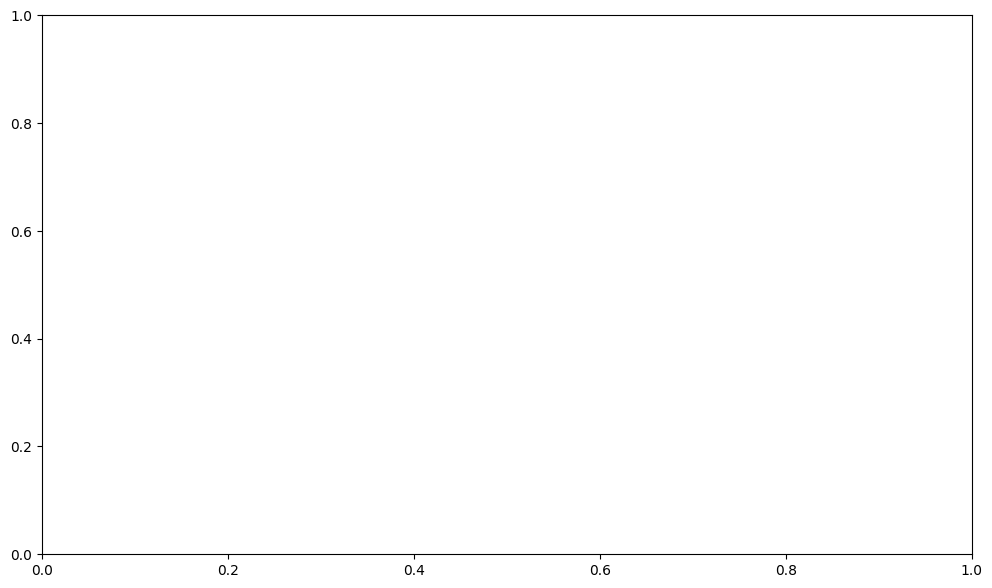

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    # Buat DataFrame
    df1 = pd.DataFrame(rekap_hasil)
    df1['Eksperimen'] = 'Percobaan 1 (1-Layer, Win 30)'
    
    df2 = pd.DataFrame(rekap_exp2)
    df2['Eksperimen'] = 'Percobaan 2 (2-Layer, Win 10)'
    
    # Gabungkan
    df_total = pd.concat([df1, df2], ignore_index=True)
    
    # SOLUSI ERROR: Paksa kolom Skenario menjadi string agar bisa di-sort
    df_total['Skenario'] = df_total['Skenario'].astype(str)
    df_total = df_total.sort_values(by=['Skenario', 'Eksperimen'])

    # ========================================================
    # 2. VISUALISASI PERBANDINGAN MAPE (VERSI MATPLOTLIB)
    # ========================================================
    # Ambil label unik yang sudah diubah ke string
    labels = sorted(df_total['Skenario'].unique())
    
    # Filter nilai MAPE untuk tiap eksperimen
    mape_exp1 = df_total[df_total['Eksperimen'].str.contains('1')]['MAPE (%)'].values
    mape_exp2 = df_total[df_total['Eksperimen'].str.contains('2')]['MAPE (%)'].values

    x = np.arange(len(labels)) 
    width = 0.35 

    fig, ax = plt.subplots(figsize=(12, 7))
    rects1 = ax.bar(x - width/2, mape_exp1, width, label='Percobaan 1 (Win 30)', color='#440154')
    rects2 = ax.bar(x + width/2, mape_exp2, width, label='Percobaan 2 (Win 10)', color='#21918c')

    # Detail Grafik sesuai standar Jurnal Mushliha
    ax.set_ylabel('MAPE (%) - Semakin Rendah Semakin Baik', fontsize=12)
    ax.set_title('Analisis Perbandingan Akurasi (MAPE)\nAntar Eksperimen dan Skenario Pembagian Data', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # [cite_start]Garis ambang batas "Sangat Akurat" sesuai Lewis Scale (<10%) [cite: 692]
    ax.axhline(y=10, color='red', linestyle='--', label='Batas Sangat Akurat (<10%)')

    # Tambahkan Label Angka di Atas Bar
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}%',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, fontweight='bold')

    autolabel(rects1)
    autolabel(rects2)

    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ========================================================
    # 3. TABEL FINAL UNTUK BAB 4 TA (HASIL & PEMBAHASAN)
    # ========================================================
    print("\n" + "="*100)
    print("TABEL PERBANDINGAN AKHIR: EVALUASI PERFORMA MODEL CNN-BiLSTM PADA SAHAM INDF")
    print("="*100)
    # [cite_start]Menampilkan metrik lengkap sesuai target di Proposal 
    kolom_tampil = ['Eksperimen', 'Skenario', 'RMSE', 'MAE', 'MAPE (%)', 'R2', 'Kategori']
    print(df_total[kolom_tampil].to_string(index=False))
    print("="*100)
    
    # Simpan hasil untuk lampiran
    df_total.to_csv('Hasil_Eksperimen_Final.csv', index=False)
    print("\n✅ Analisis selesai! File 'Hasil_Eksperimen_Final.csv' siap digunakan untuk lampiran TA.")

except Exception as e:
    print(f"❌ Terjadi kesalahan: {e}")
    print("Saran: Pastikan sel Percobaan 1 dan Percobaan 2 sudah dijalankan secara berurutan dalam satu sesi.")

In [27]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
